In [207]:
# Import Libraries
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import openpyxl

In [208]:
# Load adds data
df_adds = pd.read_csv('provided-reasources/DataAnalyst_Ecom_data_addsToCart.csv')

df_adds.head()

,dim_year,dim_month,addsToCart
0,2012,7,191504
1,2012,8,217666
2,2012,9,123726
3,2012,10,139803
4,2012,11,186572


In [209]:
# Load session data
df_ses = pd.read_csv('provided-reasources/DataAnalyst_Ecom_data_sessionCounts.csv')

# Remove data from any browsers that were never used to complete a transaction
    # These are most likely websrapers or search engine bots and not actual customers
    # Removing them will make the data more useful for the web development team

browsers = df_ses[['dim_browser','transactions']].groupby('dim_browser').sum()
bad_browsers = list(browsers[browsers['transactions'] == 0].index)

print(df_ses.shape)

df_ses.drop(df_ses[df_ses['dim_browser'].isin(bad_browsers)].index, inplace=True)

print(df_ses.shape)

df_ses.head()

(7734, 6)
(6609, 6)


,dim_browser,dim_deviceCategory,dim_date,sessions,transactions,QTY
0,Safari,tablet,7/1/12,2928,127,221
1,Internet Explorer,desktop,7/1/12,1106,28,0
2,Chrome,tablet,7/1/12,474,3,13
3,Amazon Silk,tablet,7/1/12,235,4,5
4,Internet Explorer,mobile,7/1/12,178,6,11


In [210]:
# Extract date time, and format month names
for i in df_ses.index:
    date = df_ses.loc[i,'dim_date']
    dt = datetime.strptime(date, "%m/%d/%y")   
    df_ses.loc[i,'dt'] = dt
    df_ses.loc[i,'month'] = str(dt.year) + '-' + str(dt.strftime('%m'))

df_ses.head()

,dim_browser,dim_deviceCategory,dim_date,sessions,transactions,QTY,dt,month
0,Safari,tablet,7/1/12,2928,127,221,2012-07-01,2012-07
1,Internet Explorer,desktop,7/1/12,1106,28,0,2012-07-01,2012-07
2,Chrome,tablet,7/1/12,474,3,13,2012-07-01,2012-07
3,Amazon Silk,tablet,7/1/12,235,4,5,2012-07-01,2012-07
4,Internet Explorer,mobile,7/1/12,178,6,11,2012-07-01,2012-07


In [211]:
# Create sheet1 with a groupby function
sheet1 = df_ses[['dim_deviceCategory', 'sessions', 'transactions', 'QTY', 'month']].groupby(by=['month', 'dim_deviceCategory']).sum()

# Add an ECR column
sheet1['ECR'] = sheet1['transactions'] / sheet1['sessions']

sheet1.head()

sessions  transactions    QTY       ECR
month   dim_deviceCategory                                         
2012-07 desktop               335119         10701  18547  0.031932
        mobile                274388          2576   4557  0.009388
        tablet                158712          4884   8700  0.030773
2012-08 desktop               391557         12912  23316  0.032976
        mobile                275513          3165   5572  0.011488

Text(0.5, 0, 'Month')

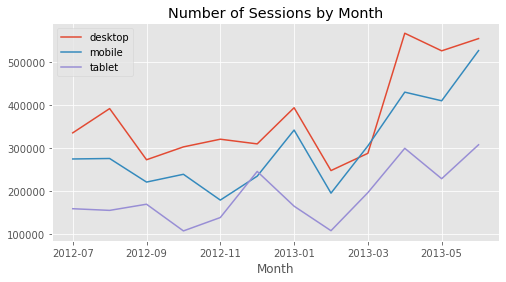

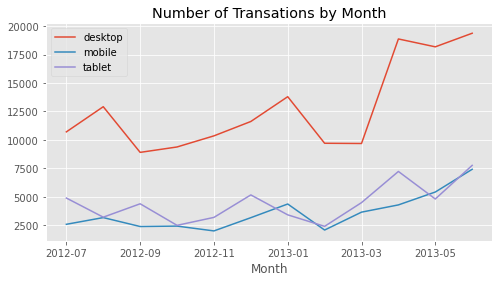

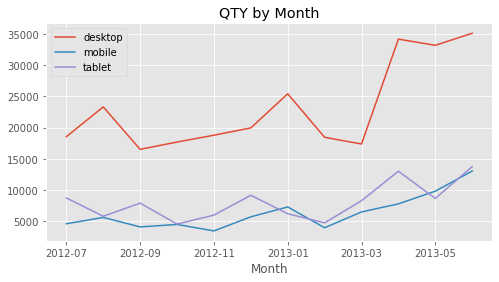

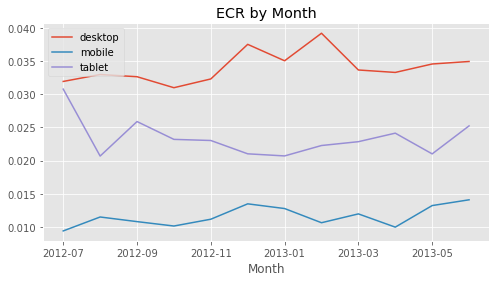

In [227]:
# Graph sessions, transactions, QTY, and ECR data over time for each platform
graph1 = sheet1.reset_index()

sessions = graph1.drop(['dim_deviceCategory', 'sessions', 'transactions', 'QTY', 'ECR'], axis=1)
transactions = graph1.drop(['dim_deviceCategory', 'sessions', 'transactions', 'QTY', 'ECR'], axis=1)
qty = graph1.drop(['dim_deviceCategory', 'sessions', 'transactions', 'QTY', 'ECR'], axis=1)
ecr = graph1.drop(['dim_deviceCategory', 'sessions', 'transactions', 'QTY', 'ECR'], axis=1)

for i in graph1.index:
    if graph1.loc[i,'dim_deviceCategory'] == 'desktop':
        sessions.loc[i,'desktop'] = graph1.loc[i,'sessions']
        transactions.loc[i,'desktop'] = graph1.loc[i,'transactions']
        qty.loc[i,'desktop'] = graph1.loc[i,'QTY']
        ecr.loc[i,'desktop'] = graph1.loc[i,'ECR']

    if graph1.loc[i,'dim_deviceCategory'] == 'mobile':
        sessions.loc[i-1,'mobile'] = graph1.loc[i,'sessions']
        transactions.loc[i-1,'mobile'] = graph1.loc[i,'transactions']
        qty.loc[i-1,'mobile'] = graph1.loc[i,'QTY']
        ecr.loc[i-1,'mobile'] = graph1.loc[i,'ECR']

    if graph1.loc[i,'dim_deviceCategory'] == 'tablet':
        sessions.loc[i-2,'tablet'] = graph1.loc[i,'sessions']
        transactions.loc[i-2,'tablet'] = graph1.loc[i,'transactions']
        qty.loc[i-2,'tablet'] = graph1.loc[i,'QTY']
        ecr.loc[i-2,'tablet'] = graph1.loc[i,'ECR']

sessions.dropna(inplace=True)
sessions.set_index(['month'], inplace=True)
sessions[['desktop', 'mobile', 'tablet']].plot(kind='line', figsize=(8,4))
plt.title('Number of Sessions by Month')
plt.xlabel('Month')

transactions.dropna(inplace=True)
transactions.set_index(['month'], inplace=True)
transactions[['desktop', 'mobile', 'tablet']].plot(kind='line', figsize=(8,4))
plt.title('Number of Transations by Month')
plt.xlabel('Month')

qty.dropna(inplace=True)
qty.set_index(['month'], inplace=True)
qty[['desktop', 'mobile', 'tablet']].plot(kind='line', figsize=(8,4))
plt.title('QTY by Month')
plt.xlabel('Month')

ecr.dropna(inplace=True)
ecr.set_index(['month'], inplace=True)
ecr[['desktop', 'mobile', 'tablet']].plot(kind='line', figsize=(8,4))
plt.title('ECR by Month')
plt.xlabel('Month')


In [213]:
# Create sheet2 using a grouby function
sheet2 = df_ses[['sessions', 'transactions', 'QTY', 'month']].groupby(by=['month']).sum()

# Get the data concerning the two most recent months
sheet2.sort_index(ascending=False, inplace=True)
sheet2 = sheet2.head(2)

# Create a column for ECR
sheet2['ECR'] = sheet2['transactions'] / sheet2['sessions']

# Add the data from df_adds
sheet2.reset_index(inplace=True)

for i in sheet2.index:
    date = sheet2.loc[i,'month'].split('-')
    year = int(date[0])
    month = int(date[1])
    x = df_adds[(df_adds['dim_year'] == year) & (df_adds['dim_month'] == month)]['addsToCart'].to_list()[0]
    sheet2.loc[i,'addsToCart'] = x

# Format the sheet to display month names and differneces
sheet2 = sheet2.transpose()

month0 = sheet2.loc['month',0]
month1 = sheet2.loc['month',1]
sheet2.rename(columns = {0:month0, 1:month1}, inplace = True)

sheet2.drop(['month'], inplace=True)
sheet2['absolute_dif'] = sheet2[month0] - sheet2[month1]
sheet2['relative_dif'] = sheet2['absolute_dif'] / sheet2[month1]

sheet2

,2013-06,2013-05,absolute_dif,relative_dif
sessions,1388160,1164113,224047,0.192462
transactions,34538,28389,6149,0.216598
QTY,61891,51629,10262,0.198764
ECR,0.02488,0.024387,0.000494,0.020241
addsToCart,107970.0,136720.0,-28750.0,-0.210284


In [214]:
# Create sheet3 containing a breakdown of session data by day of the week
sheet3 = df_ses[['dim_deviceCategory', 'sessions', 'transactions', 'QTY', 'dt']].copy()
sheet3['weekday_no'] = pd.DatetimeIndex(sheet3['dt']).weekday
sheet3 = sheet3[['sessions', 'transactions', 'QTY','weekday_no']].groupby('weekday_no').mean()

# Add ECR column
sheet3['ECR'] = sheet3['transactions'] / sheet3['sessions']

# Reformat the days of the week for readability
weekdays = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

for i in sheet3.index:
    sheet3.loc[i,'weekday'] = weekdays[i]

sheet3.set_index('weekday', inplace=True)

sheet3

,sessions,transactions,QTY,ECR
weekday,,,,
Sun,1439.516578,34.016043,60.734759,0.023630
Mon,1418.866446,33.456954,60.973510,0.023580
Tue,1676.806210,37.589936,68.866167,0.022418
Wed,1674.064414,39.027455,70.991552,0.023313
Thu,1611.001053,38.881053,71.178947,0.024135
Fri,1668.475758,44.046465,78.179798,0.026399
Sat,1529.738120,36.881732,65.713833,0.024110


Text(0.5, 0, 'Weekday')

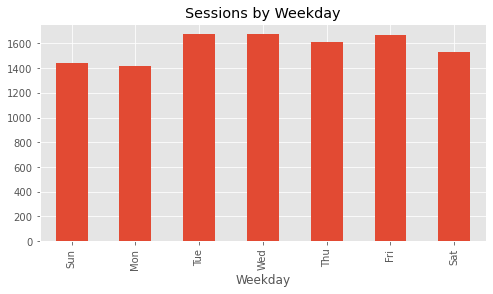

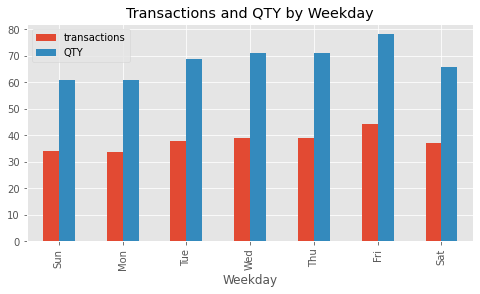

In [228]:
# Plot Data
sheet3['sessions'].plot(kind='bar', figsize=(8,4))
plt.title('Sessions by Weekday')
plt.xlabel('Weekday')

sheet3[['transactions', 'QTY']].plot(kind='bar', figsize=(8,4))
plt.title('Transactions and QTY by Weekday')
plt.xlabel('Weekday')

Text(0, 0.5, 'Transaction Count')

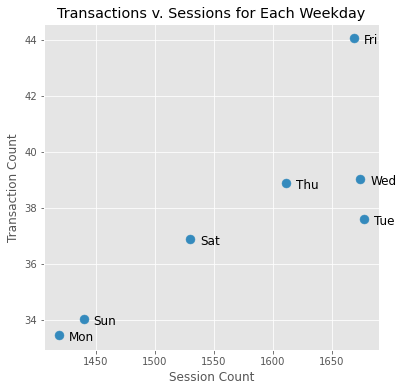

In [229]:
# Plot Transactions v. Sessions for days of the week
fig, ax = plt.subplots()
sheet3.plot(kind='scatter', x='sessions', y='transactions', ax=ax, s=80, figsize=(6,6))

for k, v in sheet3[['sessions', 'transactions']].iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=12)

plt.title('Transactions v. Sessions for Each Weekday')
plt.xlabel('Session Count')
plt.ylabel('Transaction Count')


In [217]:
# Create sheet4 with ecr data from each remaining browser
sheet4 = df_ses[['dim_browser','sessions','transactions','QTY']].groupby('dim_browser').sum()

# Add ECR column
sheet4['ECR'] = sheet4['transactions'] / sheet4['sessions']
sheet4.sort_values('sessions', ascending=False, inplace=True)

sheet4

,sessions,transactions,QTY,ECR
dim_browser,,,,
Safari,5952256,140847,263776,0.023663
Chrome,2527254,66247,125468,0.026213
Safari (in-app),518573,3046,5113,0.005874
Firefox,495779,17376,31279,0.035048
Internet Explorer,469325,14373,11016,0.030625
Edge,246329,6338,11814,0.025730
Android Webview,98408,289,406,0.002937
Samsung Internet,56632,456,774,0.008052
Amazon Silk,35379,524,836,0.014811


(-300000.0, 7000000.0)

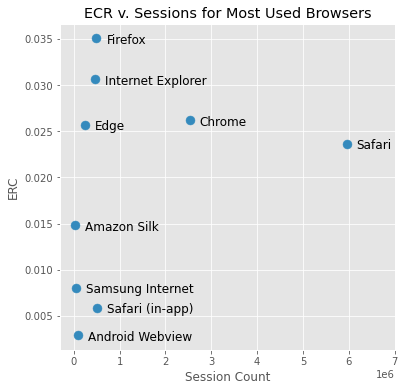

In [253]:
# Plot ECR v. Sessions for most used browsers
graph2 = sheet4.drop(sheet4[sheet4['sessions'] < 10000].index, axis=0)

fig, ax = plt.subplots()
graph2.plot(kind='scatter', x='sessions', y='ECR', ax=ax, s=80, figsize=(6,6))

for k, v in graph2[['sessions', 'ECR']].iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=12)

plt.title('ECR v. Sessions for Most Used Browsers')
plt.xlabel('Session Count')
plt.ylabel('ERC')
plt.xlim(-.3e6,7e6)


(0.0, 0.009)

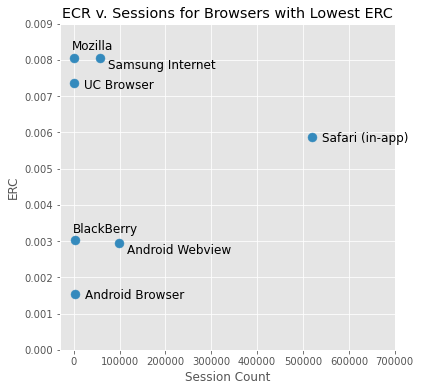

In [258]:
# Plot ECR v. Sessions for browsers with lowest ERC
graph3 = sheet4.drop(sheet4[sheet4['ECR'] > 0.01].index, axis=0)
graph3.sort_values('sessions', inplace=True)

fig, ax = plt.subplots()
graph3.plot(kind='scatter', x='sessions', y='ECR', ax=ax, s=80, figsize=(6,6))

for k, v in graph3[['sessions', 'ECR']].tail(7).iterrows():
    if k in ['Mozilla', 'BlackBerry']:
        offset = (-2,8)
    elif k in ['Samsung Internet', 'Android Webview']:
        offset = (8,-10)
    else:
        offset = (10,-5)

    ax.annotate(k, v,
                xytext=offset, textcoords='offset points',
                family='sans-serif', fontsize=12)

plt.title('ECR v. Sessions for Browsers with Lowest ERC')
plt.xlabel('Session Count')
plt.ylabel('ERC')
plt.xlim(-30000,700000)
plt.ylim(0,.009)

In [226]:
# Export data to Excel
with pd.ExcelWriter('python_worksheets.xlsx') as writer:
    sheet1.to_excel(writer, sheet_name='Volume by Month + Device')
    sheet2.to_excel(writer, sheet_name='Month Over Month Comparison')
    sheet3.to_excel(writer, sheet_name='Ave Volume By Weekday')
    sheet4.to_excel(writer, sheet_name='Volume by Browser')